In [2]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

In [43]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train', padding_dim=1543):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()
        self.padding_dim = padding_dim

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_all.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float()

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        # print(first_conversation_id)
        # print(conv_pairs)
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,self.padding_dim), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


In [4]:
class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes=1, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_classes)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [44]:
vision_model = PairDetector(input_dim=1543,
                        hidden_dim=1024,
                        n_layers=4)

audio_model = PairDetector(input_dim=2055,
                        hidden_dim=2048,
                        n_layers=4)

text_model = PairDetector(input_dim=1543,
                        hidden_dim=1024,
                        n_layers=4)


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
vision_model.load_state_dict(torch.load('/project/msoleyma_1026/ecp/models/pair/late/pair_detection_model_late_video.pt'))
audio_model.load_state_dict(torch.load('/project/msoleyma_1026/ecp/models/pair/late/pair_detection_model_late_audio.pt'))
text_model.load_state_dict(torch.load('/project/msoleyma_1026/ecp/models/pair/late/pair_detection_model_late_text.pt'))

<All keys matched successfully>

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vision_model.to(device)
audio_model.to(device)
text_model.to(device)

PairDetector(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1543, out_features=1543, bias=True)
        )
        (linear1): Linear(in_features=1543, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1543, bias=True)
        (norm1): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder_emotion): Linear(in_features=1543, out_features=1, bias=True)
)

In [10]:
def late_evaluate_model_for_roc(text_model, video_model, audio_model, text_loader, video_loader, audio_loader, device):
    text_model.eval()
    video_model.eval()
    audio_model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad(), tqdm(total=len(text_loader)) as pbar:
        for (context_embeddings_text, target_pairs_text, _, _), (context_embeddings_video, target_pairs_video, _, _), (context_embeddings_audio, target_pairs_audio, _, _) in zip(text_loader, video_loader, audio_loader):
            # context_embeddings, target_pairs, _, _ = batch  
            
            pbar.update(1)
            context_embeddings_text, target_pairs_text = context_embeddings_text.to(device), target_pairs_text.to(device)
            context_embeddings_video, target_pairs_video = context_embeddings_video.to(device), target_pairs_video.to(device)
            context_embeddings_audio, target_pairs_audio = context_embeddings_audio.to(device), target_pairs_audio.to(device)

            # context_embeddings = context_embeddings.to(device)
            # target_pairs = target_pairs.to(device)
            outputs_text = text_model(context_embeddings_text)
            outputs_video = video_model(context_embeddings_video)
            outputs_audio = audio_model(context_embeddings_audio)
            # output = model(context_embeddings)

            target_pairs_text = target_pairs_text.squeeze()

            active_outputs_text = outputs_text[target_pairs_text != -1]
            sigmoid_output_text = torch.sigmoid(active_outputs_text)  

            active_outputs_video = outputs_video[target_pairs_text != -1]
            sigmoid_output_video = torch.sigmoid(active_outputs_video)     

            active_outputs_audio = outputs_audio[target_pairs_text != -1]
            sigmoid_output_audio = torch.sigmoid(active_outputs_audio) 

            combined_outputs = (sigmoid_output_text + sigmoid_output_video + sigmoid_output_audio) / 3.0             
            
            active_pairs = target_pairs_text[target_pairs_text != -1]

            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            valid_scores = combined_outputs
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels

In [47]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [51]:
def late_evaluate_model(text_model, video_model, audio_model, text_loader, video_loader, audio_loader, criterion, device, optimal_threshold):
    text_model.eval()
    video_model.eval()
    audio_model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    correct_pair = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json')
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_text_emotion.json')

    TP = 0
    FP = 0
    FN = 0
    TN = 0
    combined_TP = 0
    combined_FP = 0
    combined_FN = 0
    combined_TN = 0

    with torch.no_grad(), tqdm(total=len(text_loader)) as pbar:
        for (context_embeddings_text, target_pairs_text, conversation_ids, utterance_ids), (context_embeddings_video, target_pairs_video, _, _), (context_embeddings_audio, target_pairs_audio, _, _) in zip(text_loader, video_loader, audio_loader):
            # context_embeddings, target_pairs, _, _ = batch  
            
            pbar.update(1)
            context_embeddings_text, target_pairs_text = context_embeddings_text.to(device), target_pairs_text.to(device)
            context_embeddings_video, target_pairs_video = context_embeddings_video.to(device), target_pairs_video.to(device)
            context_embeddings_audio, target_pairs_audio = context_embeddings_audio.to(device), target_pairs_audio.to(device)

            # context_embeddings = context_embeddings.to(device)
            # target_pairs = target_pairs.to(device)
            outputs_text = text_model(context_embeddings_text)
            outputs_video = video_model(context_embeddings_video)
            outputs_audio = audio_model(context_embeddings_audio)
            # output = model(context_embeddings)

            target_pairs_text = target_pairs_text.squeeze()

            active_outputs_text = outputs_text[target_pairs_text != -1]
            sigmoid_output_text = torch.sigmoid(active_outputs_text)  

            active_outputs_video = outputs_video[target_pairs_text != -1]
            sigmoid_output_video = torch.sigmoid(active_outputs_video)     

            active_outputs_audio = outputs_audio[target_pairs_text != -1]
            sigmoid_output_audio = torch.sigmoid(active_outputs_audio)

            active_outputs = (active_outputs_audio + active_outputs_text + active_outputs_video) / 3.0
            sigmoid_output = (sigmoid_output_text + sigmoid_output_video + sigmoid_output_audio) / 3.0             
            
            active_pairs = target_pairs_text[target_pairs_text != -1]

            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()

            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # Calculate TP, FP, FN
            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            prediction_tensor = binary_predictions
            true_tensor = active_pairs
            pair_flag = -1
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        #print("comparison successful")
                        correct_pair +=1
                    if (match and true_tensor[pair_flag]==1 and prediction_tensor[pair_flag]==1):
                        combined_TP +=1
                    elif (match and prediction_tensor[pair_flag]==1 and true_tensor[pair_flag]==0):
                        combined_FP +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==1):
                        combined_FN +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==0):
                        combined_TN +=1
            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    



    print(f"Combined True Positives: {combined_TP}")
    print(f"Combined False Positives: {combined_FP}")
    print(f"Combined False Negatives: {combined_FN}")
    print(f"Combined True Negatives: {combined_TN}")
    print(f"Total samples: {total_samples}")

    combined_precision = combined_TP / (combined_TP + combined_FP) if (combined_TP + combined_FP) > 0 else 0
    combined_recall = combined_TP / (combined_TP + combined_FN) if (combined_TP + combined_FN) > 0 else 0
    combined_f1_score = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall) if (combined_precision + combined_recall) > 0 else 0

    print(f"Combined Precision: {combined_precision:.4f}, Combined Recall: {combined_recall:.4f}, Combined F1-Score: {combined_f1_score:.4f}")
    average_loss = total_loss / len(text_loader)
    accuracy = total_correct / total_samples

    combined_accuracy = correct_pair/total_samples

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return average_loss, accuracy, precision, recall, f1_score, combined_accuracy

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
100%|██████████| 34/34 [40:49<00:00, 72.05s/it]


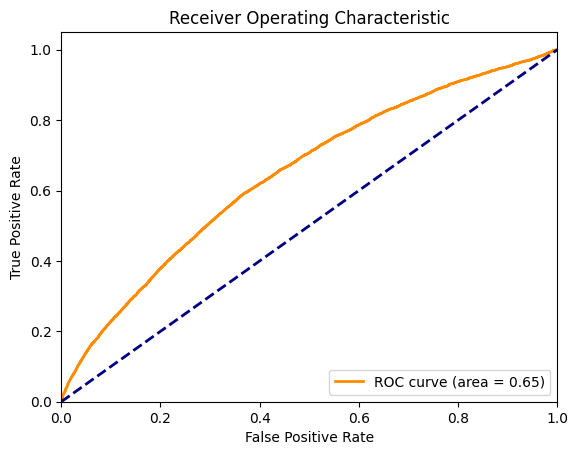

Optimal threshold for text: 0.3829770088195801


In [15]:
pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'

text_embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train-emotion'
train_dataset_roc_text = PairDataset(pairs_labels_file_roc, text_embeddings_dir_roc, mode='train', padding_dim=1543)
train_loader_roc_text = DataLoader(train_dataset_roc_text, batch_size=32, shuffle=True, collate_fn=debug_collate_fn)

audio_embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/train-emotion'
train_dataset_roc_audio = PairDataset(pairs_labels_file_roc, audio_embeddings_dir_roc, mode='train', padding_dim=2055)
train_loader_roc_audio = DataLoader(train_dataset_roc_audio, batch_size=32, shuffle=True, collate_fn=debug_collate_fn)

video_embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/train-reshaped'
train_dataset_roc_video = PairDataset(pairs_labels_file_roc, video_embeddings_dir_roc, mode='train', padding_dim=1543)
train_loader_roc_video = DataLoader(train_dataset_roc_video, batch_size=32, shuffle=True, collate_fn=debug_collate_fn)

scores, labels = late_evaluate_model_for_roc(text_model, vision_model, audio_model, train_loader_roc_text, train_loader_roc_video, train_loader_roc_audio, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold for text:', optimal_threshold)

In [53]:
data_file_test = "/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json"

vision_embeddings_dir_test = "/project/msoleyma_1026/ecp/data/pair_embeddings/video/test-reshaped"
audio_embeddings_dir_test = "/project/msoleyma_1026/ecp/data/pair_embeddings/audio/test-emotion"
text_embeddings_dir_test = "/project/msoleyma_1026/ecp/data/pair_embeddings/text/test-emotion"

vision_dataset = PairDataset(data_file_test, vision_embeddings_dir_test, mode='eval', padding_dim=1543)
text_dataset = PairDataset(data_file_test, text_embeddings_dir_test, mode='eval', padding_dim=1543)
audio_dataset = PairDataset(data_file_test, audio_embeddings_dir_test, mode='eval', padding_dim=2055)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vision_test_loader = DataLoader(vision_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)
audio_test_loader = DataLoader(audio_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)
text_test_loader = DataLoader(text_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

vision_model.to(device)
audio_model.to(device)
text_model.to(device)

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


PairDetector(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1543, out_features=1543, bias=True)
        )
        (linear1): Linear(in_features=1543, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1543, bias=True)
        (norm1): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder_emotion): Linear(in_features=1543, out_features=1, bias=True)
)

In [54]:
all_predictions = []

vision_model.eval()
audio_model.eval()
text_model.eval()

PairDetector(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1543, out_features=1543, bias=True)
        )
        (linear1): Linear(in_features=1543, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1543, bias=True)
        (norm1): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1543,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder_emotion): Linear(in_features=1543, out_features=1, bias=True)
)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.2).float())  

val_loss, val_accuracy, val_precision, val_recall, val_f1_score, combined_accuracy = late_evaluate_model(text_model, vision_model, audio_model, text_test_loader, vision_test_loader, audio_test_loader, criterion, device, optimal_threshold)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}, Combined Accuracy: {combined_accuracy:.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:34<00:00,  1.07s/it]

True Positives: 1703
False Positives: 6348
False Negatives: 90
True Negatives: 2191
Total samples: 10332
Combined True Positives: 728
Combined False Positives: 2628
Combined False Negatives: 26
Combined True Negatives: 751
Total samples: 10332
Combined Precision: 0.2169, Combined Recall: 0.9655, Combined F1-Score: 0.3543
Test Loss: 0.9357, Test Accuracy: 0.3769, Precision: 0.2115, Recall: 0.9498, F1 Score: 0.3460, Combined Accuracy: 0.1431
